# Modellierung & Dashboard-Vorbereitung

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv("../candy-data.csv")

In [ ]:
# Features & Target
X = df.drop(columns=['competitorname', 'winpercent'])
y = df['winpercent']

# # Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



### Linear Regression

In [4]:
X_ols = df.drop(columns=['competitorname', 'winpercent'])  
y_ols = df['winpercent']  

X_ols = sm.add_constant(X_ols)

ols_model = sm.OLS(y_ols, X_ols).fit()

# Print summary table
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     7.797
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           9.50e-09
Time:                        11:32:46   Log-Likelihood:                -315.64
No. Observations:                  85   AIC:                             655.3
Df Residuals:                      73   BIC:                             684.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               34.5340      4.320  

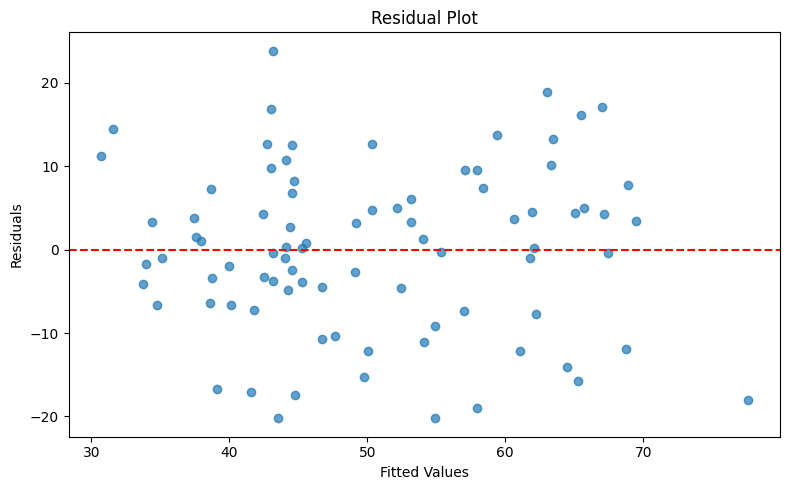

In [5]:
# Vorhersagen und Residuen
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

# Plot: Fitted Values vs. Residuen
plt.figure(figsize=(8, 5))
plt.scatter(fitted_vals, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

In [6]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Berechne Breusch-Pagan-Test
bp_test = het_breuschpagan(residuals, X_ols)

labels = ['LM Statistic', 'LM p-value', 'F-statistic', 'F p-value']
for label, value in zip(labels, bp_test):
    print(f"{label}: {value:.4f}")

LM Statistic: 14.5163
LM p-value: 0.2057
F-statistic: 1.3668
F p-value: 0.2071


### Decision Tree

R² scores (5-fold): [-0.03014946  0.12963427  0.18856273  0.14431306 -0.27084328]
Average R²: 0.032303466169463335
RMSE scores (5-fold): [154.76386726 139.58170888 153.36445726 242.32230172 204.17220339]
Average RMSE: 178.84090770221866


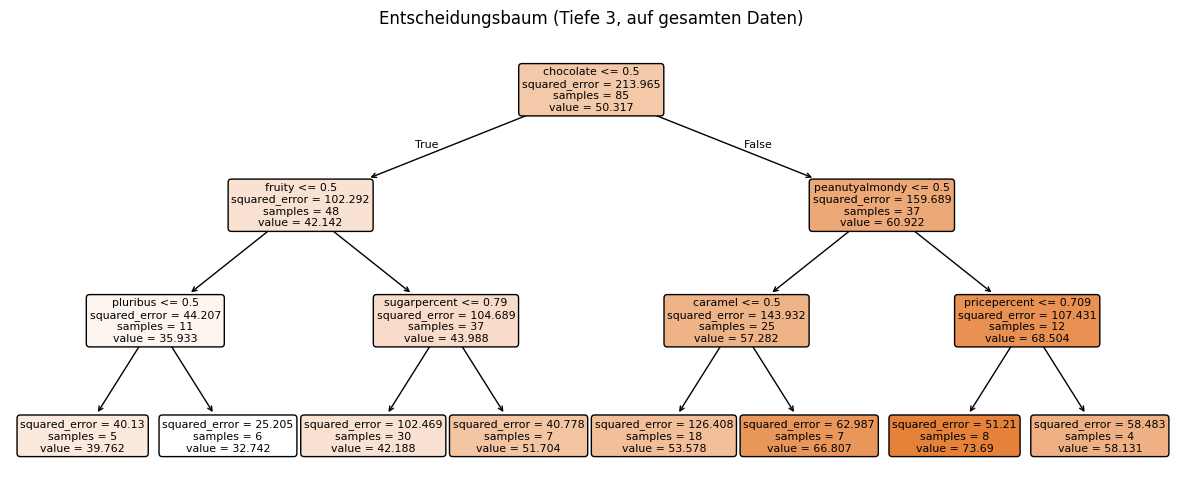

In [7]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor


# Define model
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)

# Define custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform 5-fold cross-validation
cv_results = cross_validate(
    tree_model,
    X,
    y,
    cv=5,
    scoring={'r2': 'r2', 'rmse': rmse_scorer},
    return_train_score=False
)

# Print metrics
print("R² scores (5-fold):", cv_results['test_r2'])
print("Average R²:", np.mean(cv_results['test_r2']))
print("RMSE scores (5-fold):", -cv_results['test_rmse'])  # negate because scorer returns negative
print("Average RMSE:", -np.mean(cv_results['test_rmse']))

# Optional: fit and plot one tree
tree_model.fit(X, y)
plt.figure(figsize=(15, 6))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Entscheidungsbaum (Tiefe 3, auf gesamten Daten)")
plt.show()

### Random Forest

R² Scores (per fold): [0.27324796 0.32062553 0.50372678 0.31406706 0.47299825]
Mean R² Score: 0.3769331131310021
Cross-validated RMSE: 125.53265708813584


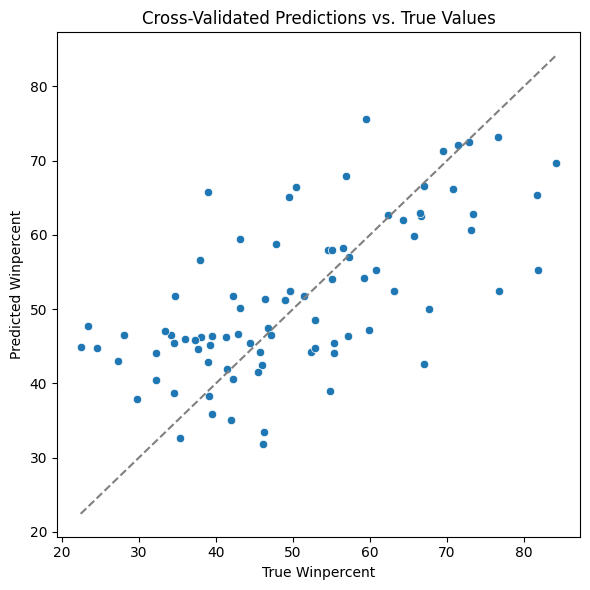

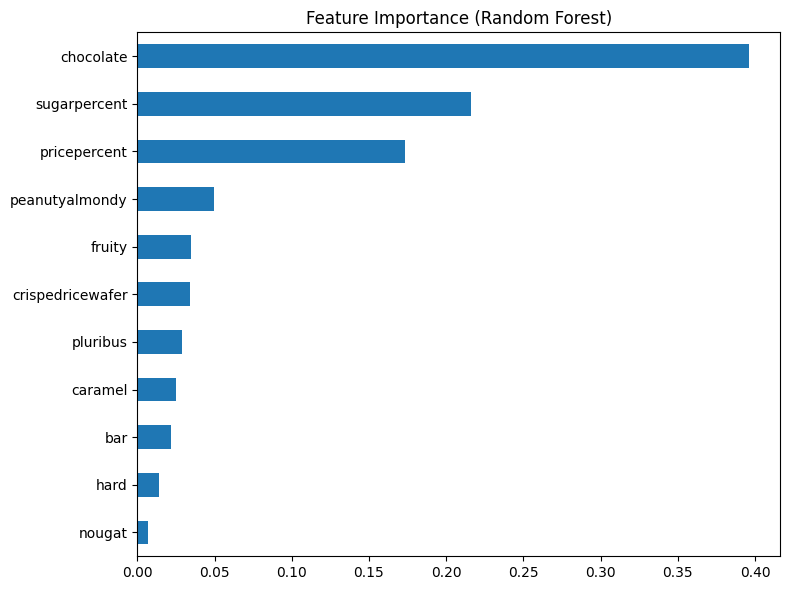

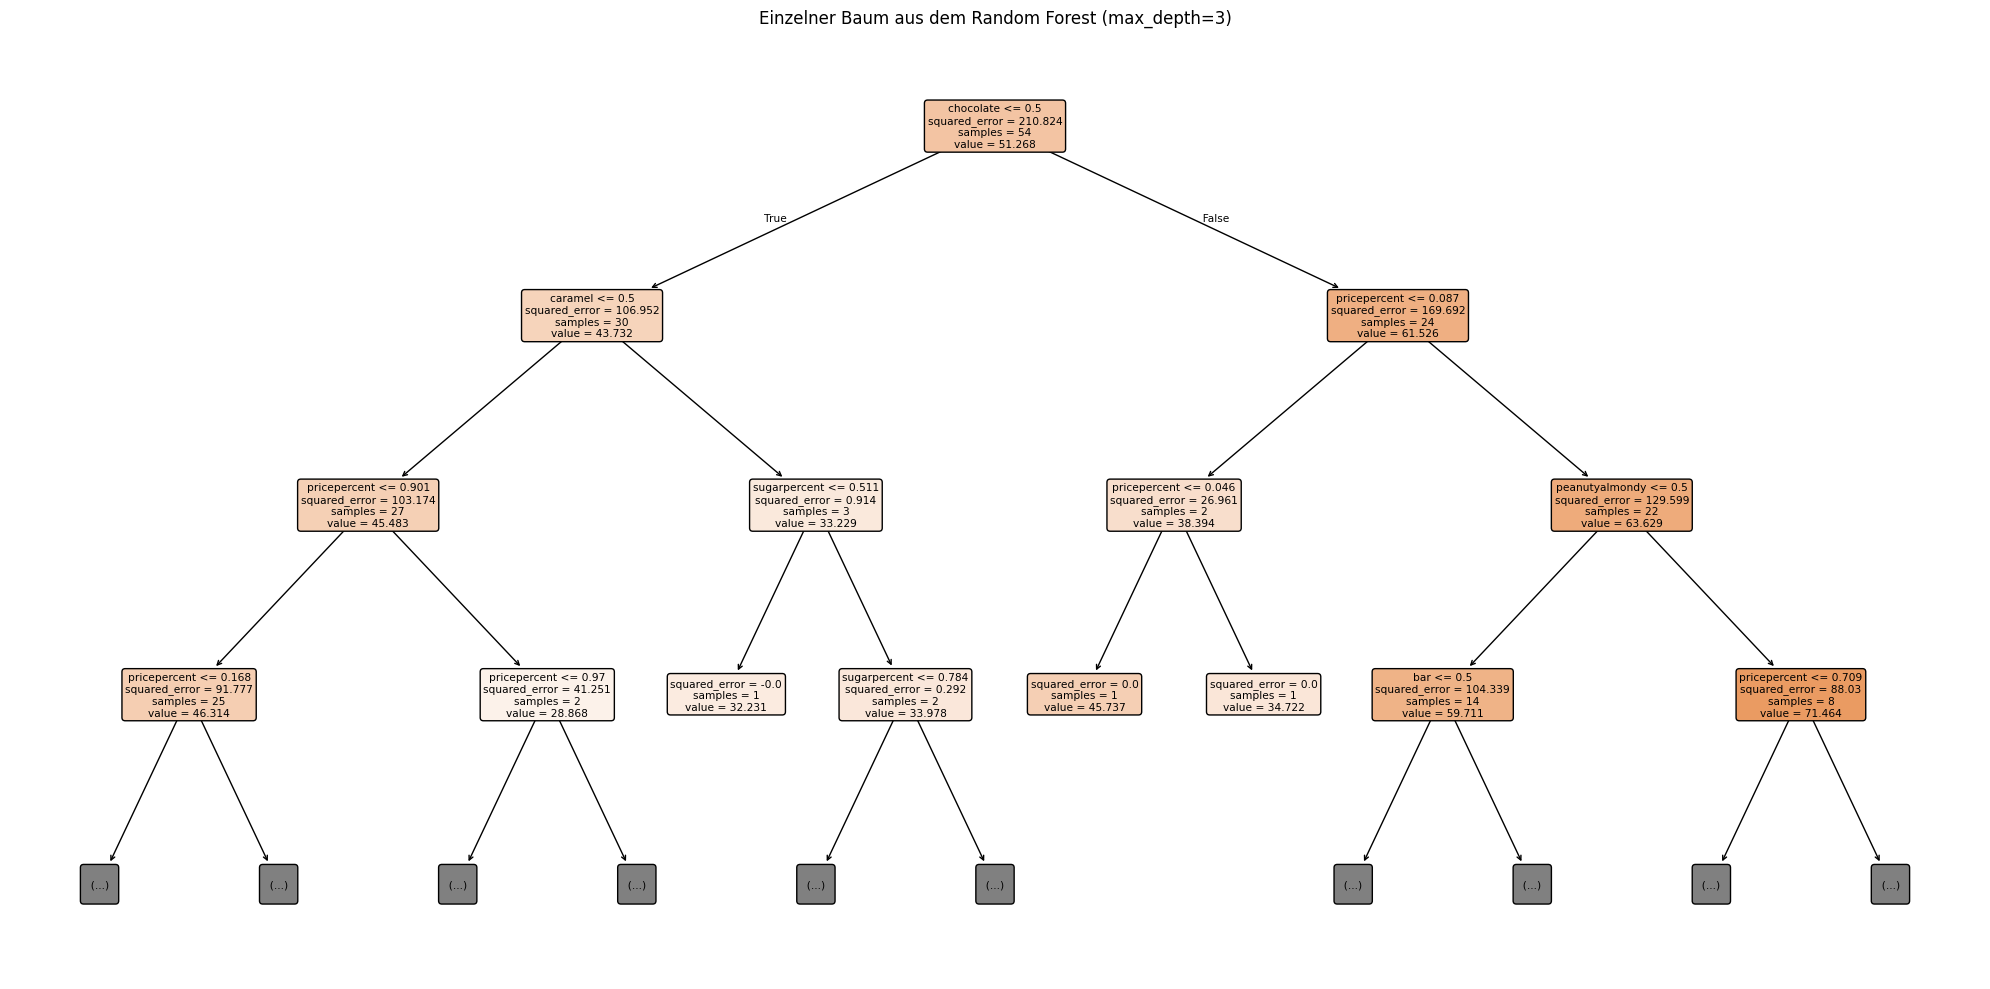

In [8]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# R² scores per fold
r2_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='r2')
print("R² Scores (per fold):", r2_scores)
print("Mean R² Score:", np.mean(r2_scores))

# Cross-validated predictions for RMSE
y_pred_cv = cross_val_predict(rf_model, X, y, cv=cv)
rmse = mean_squared_error(y, y_pred_cv)
print("Cross-validated RMSE:", rmse)

# Plot predicted vs true
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y, y=y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("True Winpercent")
plt.ylabel("Predicted Winpercent")
plt.title("Cross-Validated Predictions vs. True Values")
plt.tight_layout()
plt.show()

# --- Fit RF on full data to get feature importances ---
rf_model.fit(X, y)
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

# --- Visualize one tree ---
plt.figure(figsize=(20, 10))
plot_tree(
    rf_model.estimators_[0],
    feature_names=X.columns,
    filled=True,
    max_depth=3,
    rounded=True
)
plt.title("Einzelner Baum aus dem Random Forest (max_depth=3)")
plt.tight_layout()
plt.show()

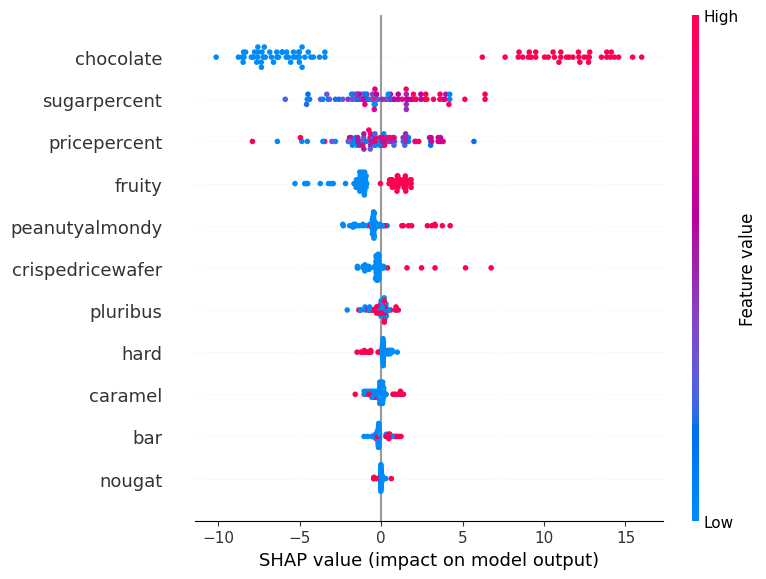

In [9]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

# Summary Plot
shap.summary_plot(shap_values, X)

### XGBOOST

XGBoost R² scores (5-fold): [-0.30256842  0.14414957  0.61180186  0.28163872  0.09918661]
Average R²: 0.16684166782806084
XGBoost RMSE scores (5-fold): [195.6905611  137.25387085  73.37079484 203.43299953 144.72363136]
Average RMSE: 150.894371537229


<Figure size 1000x600 with 0 Axes>

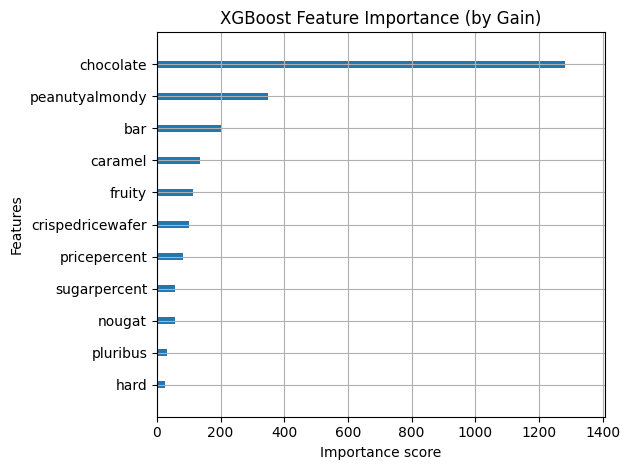

In [10]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

# Cross-validation
cv_results = cross_validate(
    xgb_model,
    X,
    y,
    cv=5,
    scoring={'r2': 'r2', 'rmse': rmse_scorer},
    return_train_score=False
)

# Output results
print("XGBoost R² scores (5-fold):", cv_results['test_r2'])
print("Average R²:", np.mean(cv_results['test_r2']))
print("XGBoost RMSE scores (5-fold):", -cv_results['test_rmse'])  # Negate because it returns negative
print("Average RMSE:", -np.mean(cv_results['test_rmse']))

# Feature Importance
xgb_model.fit(X, y)

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', show_values=False)
plt.title("XGBoost Feature Importance (by Gain)")
plt.tight_layout()
plt.show()

### Additional Exploratory Plots

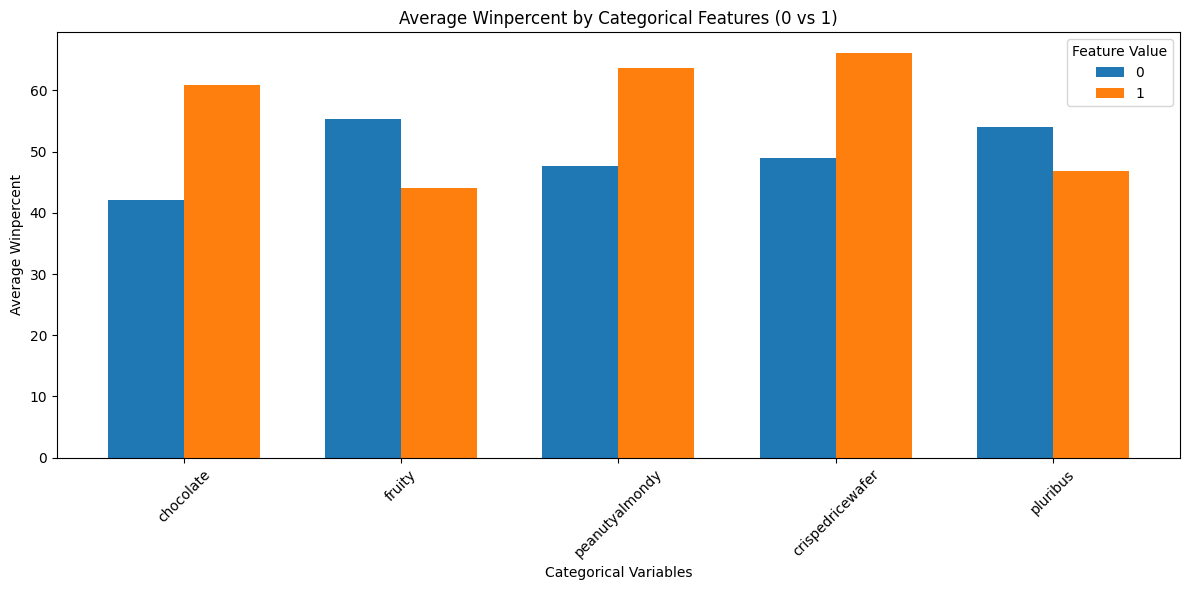

In [11]:
categorical_columns = [
    "chocolate", "fruity", "caramel", "peanutyalmondy",
    "nougat", "crispedricewafer", "hard", "bar", "pluribus"
]
importances_cat = importances[importances.index.isin(categorical_columns)]
categorical_columns = [x for x in categorical_columns if x in importances_cat.sort_values()[-5:].index]

# Calculate means for each categorical variable for 0 and 1
means_0 = []
means_1 = []
for col in categorical_columns:
    means_0.append(df[df[col] == 0]['winpercent'].mean())
    means_1.append(df[df[col] == 1]['winpercent'].mean())

# Positions on the x-axis
x = np.arange(len(categorical_columns))  # 0, 1, ..., 8

width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

bars_0 = ax.bar(x - width/2, means_0, width, label='0')
bars_1 = ax.bar(x + width/2, means_1, width, label='1')

# Labels and ticks
ax.set_xlabel('Categorical Variables')
ax.set_ylabel('Average Winpercent')
ax.set_title('Average Winpercent by Categorical Features (0 vs 1)')
ax.set_xticks(x)
ax.set_xticklabels(categorical_columns, rotation=45)
ax.legend(title='Feature Value')

plt.tight_layout()
plt.show()

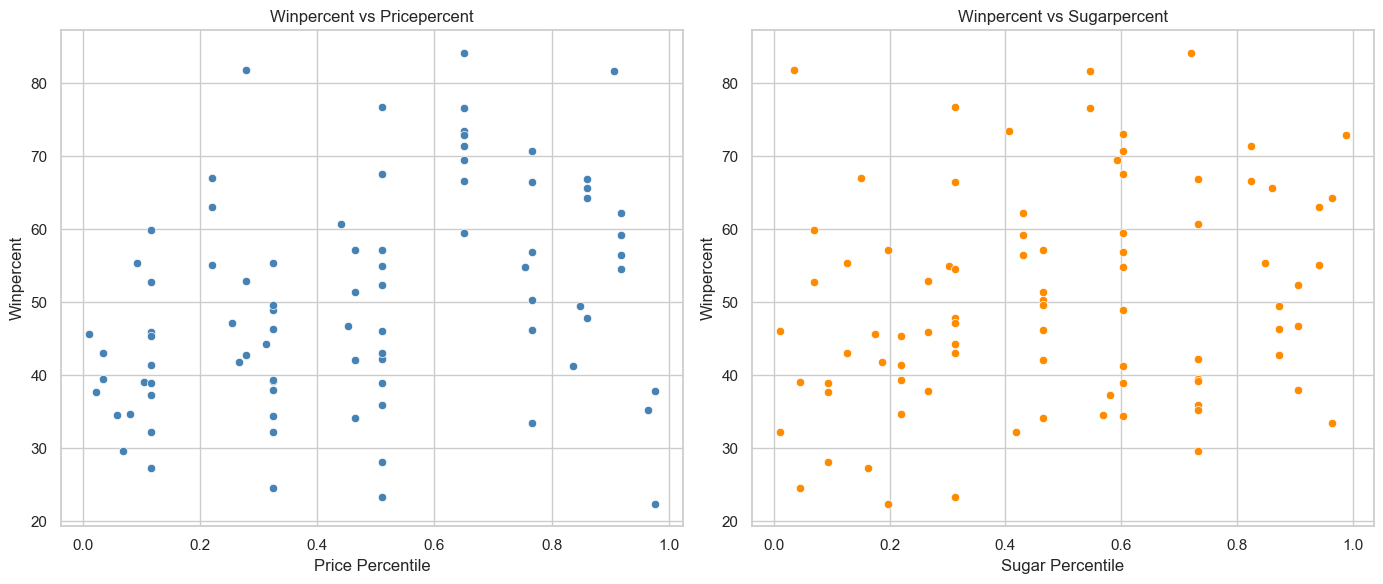

In [12]:
# Set style
sns.set(style="whitegrid")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot: winpercent vs pricepercent
sns.scatterplot(ax=axes[0], data=df, x="pricepercent", y="winpercent", color="steelblue")
axes[0].set_title("Winpercent vs Pricepercent")
axes[0].set_xlabel("Price Percentile")
axes[0].set_ylabel("Winpercent")

# Scatterplot: winpercent vs sugarpercent
sns.scatterplot(ax=axes[1], data=df, x="sugarpercent", y="winpercent", color="darkorange")
axes[1].set_title("Winpercent vs Sugarpercent")
axes[1].set_xlabel("Sugar Percentile")
axes[1].set_ylabel("Winpercent")

plt.tight_layout()
plt.show()

              winpercent  sugarpercent  pricepercent
winpercent      1.000000      0.229151      0.345325
sugarpercent    0.229151      1.000000      0.329706
pricepercent    0.345325      0.329706      1.000000


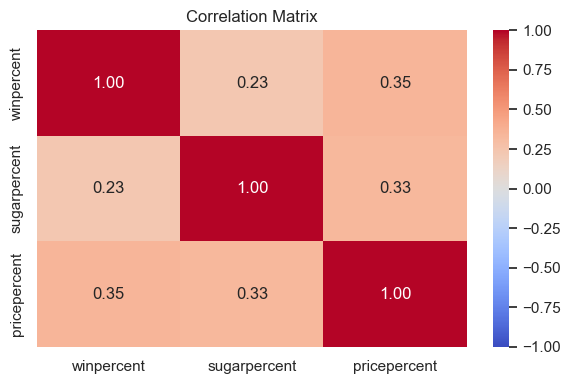

In [13]:
corr_cols = ["winpercent", "sugarpercent", "pricepercent"]
corr_matrix = df[corr_cols].corr()

# Print correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()